In [27]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

# Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.utils import resample, class_weight
from imblearn.over_sampling import SMOTE

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Style settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")
print("\n⚓ All libraries loaded successfully!")

TensorFlow version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

⚓ All libraries loaded successfully!


In [28]:
# Load training data
X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

print("🏴‍☠️ Training Data Overview")
print("=" * 50)
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"\nNumber of unique samples: {X_train['sample_index'].nunique()}")
print(f"Time steps per sample (min-max): {X_train.groupby('sample_index').size().min()} - {X_train.groupby('sample_index').size().max()}")
print(f"\nFeature columns: {X_train.shape[1]}")

🏴‍☠️ Training Data Overview
Training features shape: (105760, 40)
Training labels shape: (661, 2)

Number of unique samples: 661
Time steps per sample (min-max): 160 - 160

Feature columns: 40


In [29]:
# Display first few rows
print("\n📊 First few rows of training data:")
display(X_train.head())

print("\n🏷️ First few labels:")
display(y_train.head())


📊 First few rows of training data:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5



🏷️ First few labels:


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


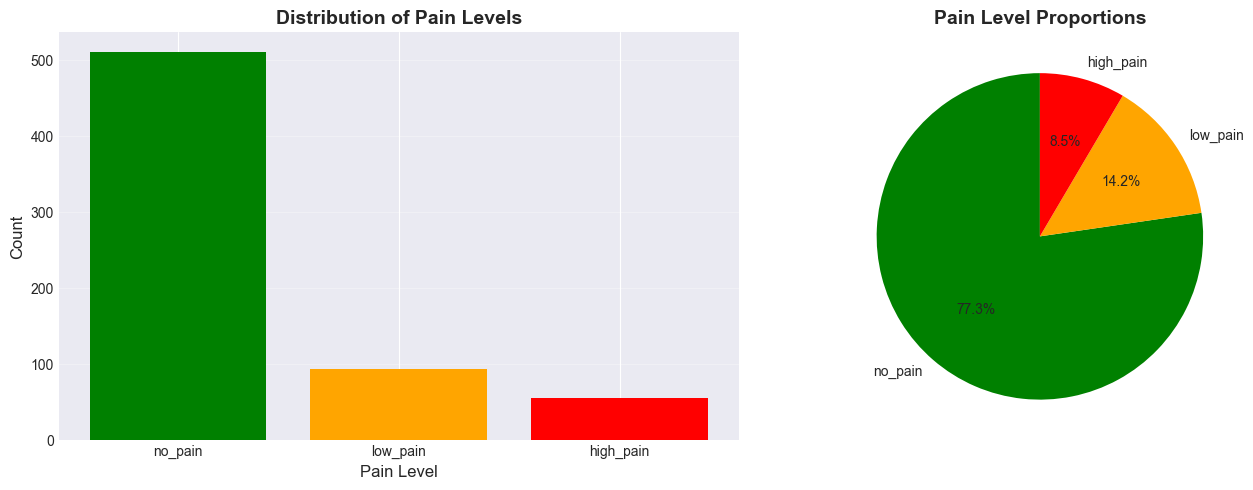


📈 Label Statistics:
label
no_pain      511
low_pain      94
high_pain     56
Name: count, dtype: int64

Class balance: 10.96%


In [30]:
# Label distribution
label_counts = y_train['label'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(label_counts.index, label_counts.values, color=['green', 'orange', 'red'])
axes[0].set_xlabel('Pain Level', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Pain Levels', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
colors = {'no_pain': 'green', 'low_pain': 'orange', 'high_pain': 'red'}
pie_colors = [colors.get(label, 'gray') for label in label_counts.index]
axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=pie_colors)
axes[1].set_title('Pain Level Proportions', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📈 Label Statistics:")
print(label_counts)
print(f"\nClass balance: {label_counts.min() / label_counts.max():.2%}")

In [31]:
# Explore feature types
print("\n🔍 Feature Analysis:")
print("=" * 50)

# Identify feature groups
pain_survey_cols = [col for col in X_train.columns if 'pain_survey' in col]
body_char_cols = ['n_legs', 'n_hands', 'n_eyes']
joint_cols = [col for col in X_train.columns if 'joint_' in col]

print(f"\n📋 Pain Survey Features: {len(pain_survey_cols)}")
print(pain_survey_cols)

print(f"\n🧍 Body Characteristics: {len(body_char_cols)}")
print(body_char_cols)

print(f"\n🦴 Joint Measurements: {len(joint_cols)}")
print(f"Joints: joint_00 to joint_{len(joint_cols)-1:02d}")

print(f"\n✅ Total features (excluding sample_index, time): {len(pain_survey_cols) + len(body_char_cols) + len(joint_cols)}")


🔍 Feature Analysis:

📋 Pain Survey Features: 4
['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

🧍 Body Characteristics: 3
['n_legs', 'n_hands', 'n_eyes']

🦴 Joint Measurements: 31
Joints: joint_00 to joint_30

✅ Total features (excluding sample_index, time): 38


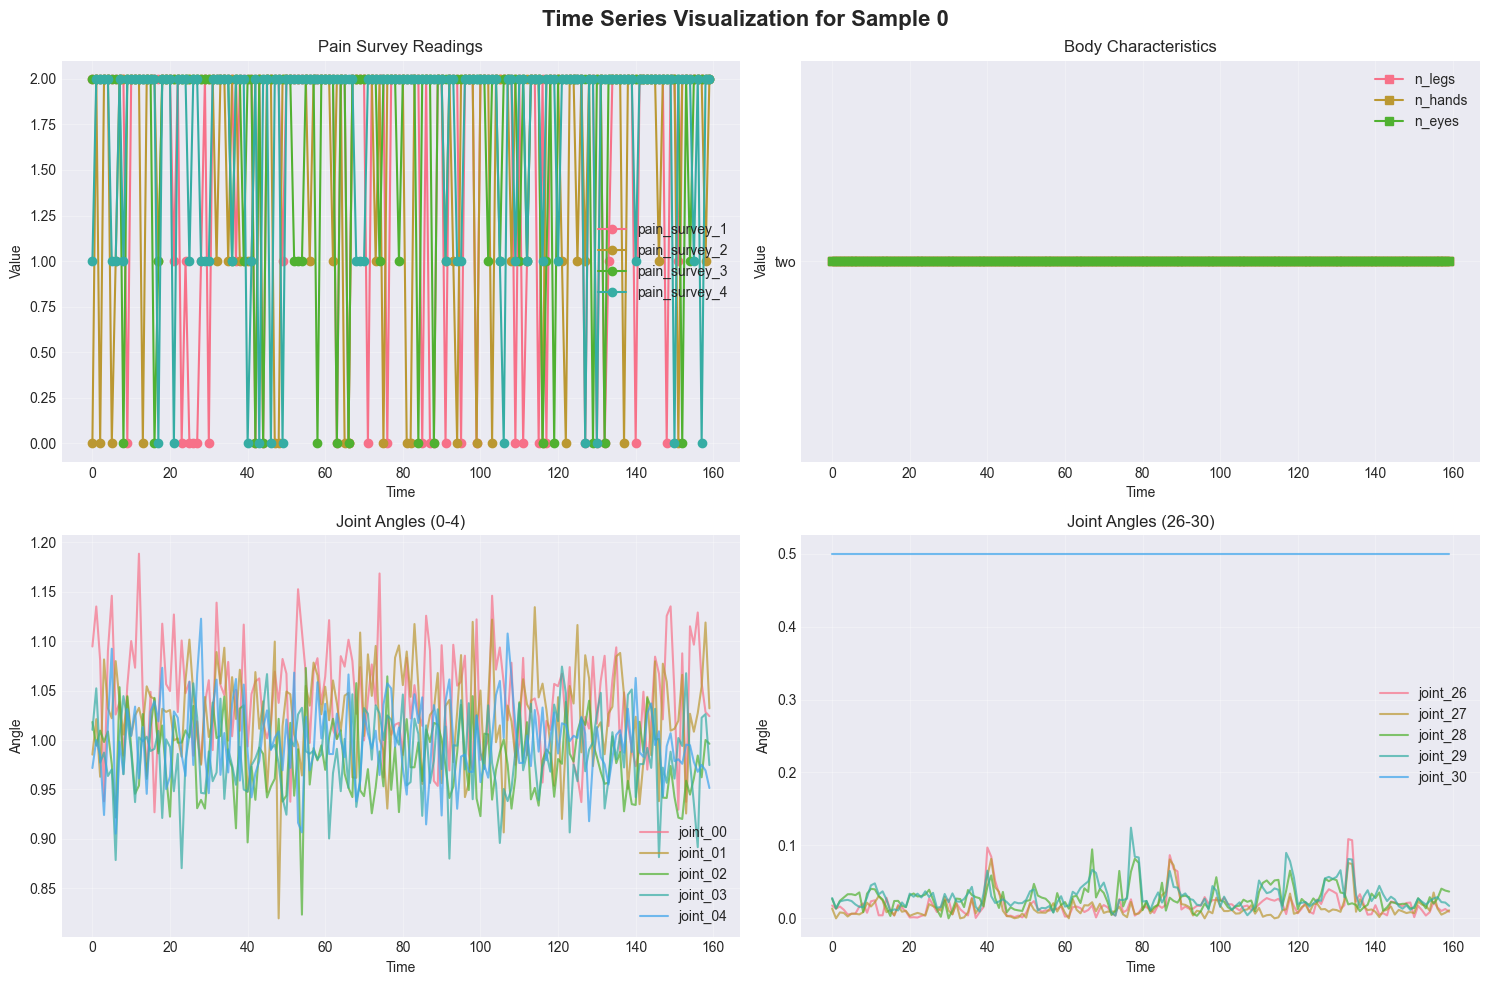

In [32]:
# Visualize a sample time series
sample_idx = 0
sample_data = X_train[X_train['sample_index'] == sample_idx].sort_values('time')

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Time Series Visualization for Sample {sample_idx}', fontsize=16, fontweight='bold')

# Pain surveys
for col in pain_survey_cols:
    axes[0, 0].plot(sample_data['time'], sample_data[col], marker='o', label=col)
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_title('Pain Survey Readings')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Body characteristics
for col in body_char_cols:
    if col in sample_data.columns:
        axes[0, 1].plot(sample_data['time'], sample_data[col], marker='s', label=col)
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_title('Body Characteristics')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# First 5 joints
for i, col in enumerate(joint_cols[:5]):
    axes[1, 0].plot(sample_data['time'], sample_data[col], label=col, alpha=0.7)
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Angle')
axes[1, 0].set_title('Joint Angles (0-4)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Last 5 joints
for col in joint_cols[-5:]:
    axes[1, 1].plot(sample_data['time'], sample_data[col], label=col, alpha=0.7)
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Angle')
axes[1, 1].set_title(f'Joint Angles ({len(joint_cols)-5}-{len(joint_cols)-1})')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [33]:
# Advanced preprocessing and augmentation utilities
from collections import defaultdict
from typing import List

CATEGORICAL_MAP = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}
CATEGORICAL_COLS = ['n_legs', 'n_hands', 'n_eyes']
PAIN_SURVEY_COLS = [f'pain_survey_{i}' for i in range(1, 5)]
JOINT_COLS = [f'joint_{i:02d}' for i in range(31)]
SIGNAL_COLS = PAIN_SURVEY_COLS + JOINT_COLS

def _map_categorical_features(df):
    for col in CATEGORICAL_COLS:
        if col in df.columns:
            mapped = df[col].map(CATEGORICAL_MAP)
            if mapped.isna().all():
                df[col] = 0
            else:
                fill_value = float(mapped.dropna().median()) if not mapped.dropna().empty else 0.0
                df[col] = mapped.fillna(fill_value)
    return df

def _interpolate_joint_signals(df, joint_cols):
    if not joint_cols:
        return df
    df.loc[:, joint_cols] = df[joint_cols].replace(0, np.nan)
    df.loc[:, joint_cols] = df[joint_cols].interpolate(method='linear', limit_direction='both', axis=0)
    df.loc[:, joint_cols] = df[joint_cols].fillna(method='bfill').fillna(method='ffill').fillna(0)
    return df

def _compute_gradients(values, time_values):
    if values.shape[0] < 2:
        zeros = np.zeros_like(values, dtype=np.float32)
        return zeros, zeros
    velocity = np.gradient(values, time_values, axis=0)
    acceleration = np.gradient(velocity, time_values, axis=0)
    return velocity.astype(np.float32), acceleration.astype(np.float32)

def _generate_energy(values):
    return np.square(values, dtype=np.float32)

def preprocess_features(sample_df):
    """Preprocess a single sample into enriched feature tensors."""
    df = sample_df.sort_values('time').reset_index(drop=True).copy()
    df = _map_categorical_features(df)
    joint_cols_present = [col for col in JOINT_COLS if col in df.columns]
    df = _interpolate_joint_signals(df, joint_cols_present)

    signal_cols_present = [col for col in SIGNAL_COLS if col in df.columns]
    time_values = df['time'].to_numpy(dtype=np.float32)
    signal_matrix = df[signal_cols_present].to_numpy(dtype=np.float32)

    velocity, acceleration = _compute_gradients(signal_matrix, time_values)
    energy = _generate_energy(signal_matrix)

    categorical_cols_present = [col for col in CATEGORICAL_COLS if col in df.columns]
    categorical_matrix = df[categorical_cols_present].to_numpy(dtype=np.float32) if categorical_cols_present else None

    components: List[np.ndarray] = []
    if categorical_matrix is not None:
        components.append(categorical_matrix.astype(np.float32))
    components.extend([signal_matrix, velocity, acceleration, energy])

    enriched = np.concatenate(components, axis=1).astype(np.float32)
    return enriched

def augment_noise(seq, sigma=0.02, rng=None):
    rng = rng or np.random.default_rng()
    noise = rng.normal(0.0, sigma, size=seq.shape).astype(np.float32)
    return (seq + noise).astype(np.float32)

def augment_scaling(seq, scale_range=(0.9, 1.1), rng=None):
    rng = rng or np.random.default_rng()
    scale = rng.uniform(*scale_range)
    return (seq * scale).astype(np.float32)

def _resample_sequence(seq, target_length):
    if seq.shape[0] == target_length:
        return seq.astype(np.float32)
    original_idx = np.linspace(0, seq.shape[0] - 1, num=seq.shape[0])
    target_idx = np.linspace(0, seq.shape[0] - 1, num=target_length)
    resampled = np.empty((target_length, seq.shape[1]), dtype=np.float32)
    for feature_idx in range(seq.shape[1]):
        resampled[:, feature_idx] = np.interp(target_idx, original_idx, seq[:, feature_idx])
    return resampled

def augment_timewarp(seq, stretch_range=(0.8, 1.2), rng=None):
    rng = rng or np.random.default_rng()
    stretch = rng.uniform(*stretch_range)
    target_length = max(2, int(round(seq.shape[0] * stretch)))
    stretched = _resample_sequence(seq, target_length)
    return _resample_sequence(stretched, seq.shape[0])

def augment_dropout(seq, drop_prob=0.1, rng=None):
    rng = rng or np.random.default_rng()
    augmented = seq.copy()
    mask = rng.random(seq.shape[0]) < drop_prob
    augmented[mask] = 0.0
    return augmented.astype(np.float32)

def augment_mixup(seq, partner_seq, alpha=0.2, rng=None):
    rng = rng or np.random.default_rng()
    beta = rng.beta(alpha, alpha)
    partner_resampled = _resample_sequence(partner_seq, seq.shape[0])
    mixed = beta * seq + (1 - beta) * partner_resampled
    return mixed.astype(np.float32)

print("✅ Advanced preprocessing and augmentation utilities ready!")

✅ Advanced preprocessing and augmentation utilities ready!


In [34]:
# Create sequences with advanced preprocessing, feature engineering, and augmentation
print("🔄 Building enriched sequences...")

rng = np.random.default_rng(42)
base_sequences = []
labels = []
class_to_indices = defaultdict(list)

sample_indices = X_train['sample_index'].unique()

for sample_idx in sample_indices:
    sample_data = X_train[X_train['sample_index'] == sample_idx].copy()
    processed_sequence = preprocess_features(sample_data)
    base_sequences.append(processed_sequence)
    label = y_train[y_train['sample_index'] == sample_idx]['label'].iloc[0]
    labels.append(label)
    class_to_indices[label].append(len(base_sequences) - 1)

original_sample_count = len(base_sequences)
min_len = min(seq.shape[0] for seq in base_sequences)
max_len = max(seq.shape[0] for seq in base_sequences)
feature_dim = base_sequences[0].shape[1]

print(f"✅ Created {original_sample_count} base sequences")
print(f"   Sequence length range: {min_len} - {max_len} time steps")
print(f"   Feature dimensionality per timestep: {feature_dim}")

augmentation_pool = ['noise', 'scaling', 'timewarp', 'dropout', 'mixup']
augmented_sequences = []
augmented_labels = []

for idx, (sequence, label) in enumerate(zip(base_sequences, labels)):
    if rng.random() < 0.5:
        augmented = sequence.copy()
        n_augs = int(rng.integers(1, 4))
        chosen = rng.choice(augmentation_pool, size=n_augs, replace=False)
        for aug_name in chosen:
            if aug_name == 'noise':
                augmented = augment_noise(augmented, sigma=0.02, rng=rng)
            elif aug_name == 'scaling':
                augmented = augment_scaling(augmented, scale_range=(0.9, 1.1), rng=rng)
            elif aug_name == 'timewarp':
                augmented = augment_timewarp(augmented, stretch_range=(0.8, 1.2), rng=rng)
            elif aug_name == 'dropout':
                augmented = augment_dropout(augmented, drop_prob=0.1, rng=rng)
            elif aug_name == 'mixup':
                partners = [p for p in class_to_indices[label] if p != idx]
                if not partners:
                    partners = class_to_indices[label]
                partner_idx = int(rng.choice(partners))
                partner_sequence = base_sequences[partner_idx]
                augmented = augment_mixup(augmented, partner_sequence, alpha=0.2, rng=rng)
        augmented_sequences.append(augmented.astype(np.float32))
        augmented_labels.append(label)

augmented_sample_count = original_sample_count + len(augmented_sequences)

print(f"✨ Augmented sequences generated: {len(augmented_sequences)}")
print(f"   Total sequences after augmentation: {augmented_sample_count}")

all_sequences = base_sequences + augmented_sequences
labels.extend(augmented_labels)

scaler = StandardScaler()
stacked_matrix = np.vstack(all_sequences)
scaler.fit(stacked_matrix)
samples = [scaler.transform(seq).astype(np.float32) for seq in all_sequences]
print("✅ Feature scaling applied after augmentation")

🔄 Building enriched sequences...
✅ Created 661 base sequences
   Sequence length range: 160 - 160 time steps
   Feature dimensionality per timestep: 143
✨ Augmented sequences generated: 335
   Total sequences after augmentation: 996
✅ Created 661 base sequences
   Sequence length range: 160 - 160 time steps
   Feature dimensionality per timestep: 143
✨ Augmented sequences generated: 335
   Total sequences after augmentation: 996
✅ Feature scaling applied after augmentation
✅ Feature scaling applied after augmentation


In [35]:
# Pad sequences to uniform length
max_len = max(seq.shape[0] for seq in samples)
n_features = samples[0].shape[1]

print(f"\n📏 Padding sequences to length: {max_len}")
print(f"   Samples before augmentation: {original_sample_count}")
print(f"   Samples after augmentation:  {augmented_sample_count}")

X_padded = np.zeros((len(samples), max_len, n_features), dtype=np.float32)
for i, sample in enumerate(samples):
    seq_length = sample.shape[0]
    X_padded[i, :seq_length, :] = sample

print(f"✅ Padded data shape: {X_padded.shape}")
print("   Format: (samples, time_steps, features)")


📏 Padding sequences to length: 160
   Samples before augmentation: 661
   Samples after augmentation:  996
✅ Padded data shape: (996, 160, 143)
   Format: (samples, time_steps, features)


In [36]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

class_counts = pd.Series(y_encoded).value_counts().sort_index()
print("\n🏷️ Label Encoding:")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label} → {i}")

print(f"\n👥 Samples before augmentation: {original_sample_count}")
print(f"🚀 Samples after augmentation:  {augmented_sample_count}")

print("\nClass counts after augmentation:")
for cls, count in class_counts.items():
    print(f"   Class {cls} ({label_encoder.classes_[cls]}): {count}")


🏷️ Label Encoding:
   high_pain → 0
   low_pain → 1
   no_pain → 2

👥 Samples before augmentation: 661
🚀 Samples after augmentation:  996

Class counts after augmentation:
   Class 0 (high_pain): 86
   Class 1 (low_pain): 143
   Class 2 (no_pain): 767


In [37]:
# Create train/validation split (80/20)
print("\n✂️ Creating train/validation split...")

X_train_seq, X_val_seq, y_train_enc, y_val_enc = train_test_split(
    X_padded, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"✅ Training set: {X_train_seq.shape[0]} samples")
print(f"✅ Validation set: {X_val_seq.shape[0]} samples")

sequence_length = X_train_seq.shape[1]
n_features = X_train_seq.shape[2]

# Show class distribution before balancing
train_dist_before = pd.Series(y_train_enc).value_counts().sort_index()
val_dist = pd.Series(y_val_enc).value_counts().sort_index()

print("\n📊 Class distribution (original training split):")
for i, label in enumerate(label_encoder.classes_):
    print(f"   {label}: Train={train_dist_before.get(i, 0)}, Val={val_dist.get(i, 0)}")

# Keep original training data for resampling experiments
X_train_base = X_train_seq.astype(np.float32)
y_train_base = y_train_enc.copy()

print("\n🧪 Stored base training tensors for balancing strategies.")




✂️ Creating train/validation split...
✅ Training set: 796 samples
✅ Validation set: 200 samples

📊 Class distribution (original training split):
   high_pain: Train=69, Val=17
   low_pain: Train=114, Val=29
   no_pain: Train=613, Val=154

🧪 Stored base training tensors for balancing strategies.


In [38]:
# Custom F1-Score Metric for Keras
class F1Score(keras.metrics.Metric):
    """
    Custom F1-Score metric for Keras
    Computes macro-averaged F1-score for multi-class classification
    """
    def __init__(self, name='f1_score', num_classes=3, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred_classes = tf.argmax(y_pred, axis=-1, output_type=tf.int32)
        
        y_true_one_hot = tf.cast(tf.one_hot(y_true, depth=self.num_classes), tf.float32)
        y_pred_one_hot = tf.cast(tf.one_hot(y_pred_classes, depth=self.num_classes), tf.float32)
        
        if sample_weight is not None:
            sample_weight = tf.cast(tf.reshape(sample_weight, [-1, 1]), tf.float32)
            y_true_one_hot *= sample_weight
            y_pred_one_hot *= sample_weight
        
        tp = tf.reduce_sum(y_true_one_hot * y_pred_one_hot, axis=0)
        fp = tf.reduce_sum((1.0 - y_true_one_hot) * y_pred_one_hot, axis=0)
        fn = tf.reduce_sum(y_true_one_hot * (1.0 - y_pred_one_hot), axis=0)
        
        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)
    
    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)
    
    def reset_state(self):
        self.true_positives.assign(tf.zeros((self.num_classes,)))
        self.false_positives.assign(tf.zeros((self.num_classes,)))
        self.false_negatives.assign(tf.zeros((self.num_classes,)))

print("✅ F1-Score metric class defined!")

✅ F1-Score metric class defined!


In [39]:
def make_sparse_focal_loss(gamma=1.5, alpha=None):
    """Build a sparse categorical focal loss with optional per-class alpha weights."""
    alpha_tensor = None
    if alpha is not None:
        alpha_tensor = tf.constant(alpha, dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_true = tf.cast(tf.reshape(y_true, [-1]), tf.int32)
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1.0 - tf.keras.backend.epsilon())
        y_true_one_hot = tf.one_hot(y_true, depth=tf.shape(y_pred)[-1])
        focal_weight = tf.pow(1.0 - y_pred, gamma)
        if alpha_tensor is not None:
            class_weights = tf.gather(alpha_tensor, y_true)
            class_weights = tf.expand_dims(class_weights, axis=-1)
            focal_weight *= class_weights
        cross_entropy = -y_true_one_hot * tf.math.log(y_pred)
        per_sample_loss = tf.reduce_sum(focal_weight * cross_entropy, axis=-1)
        return per_sample_loss

    return loss_fn

print("✅ Sparse focal loss factory defined!")

✅ Sparse focal loss factory defined!


In [40]:
def build_model(
    sequence_length, 
    n_features, 
    n_classes, 
    lstm_units=(128, 64, 32), 
    dense_units=(64, 32), 
    dropout_lstm=0.3, 
    dropout_dense=0.3, 
    learning_rate=0.001, 
    gamma=2.0, 
    alpha=None
):
    """
    Build deep LSTM model for time series classification
    All weights randomly initialized - NO pre-training!
    """
    model = models.Sequential()
    model.add(layers.Input(shape=(sequence_length, n_features), name='input_sequence'))
    model.add(layers.Masking(mask_value=0.0, name='mask_padding'))

    for idx, units in enumerate(lstm_units):
        return_sequences = idx < len(lstm_units) - 1
        model.add(layers.LSTM(units, return_sequences=return_sequences, name=f'lstm_layer_{idx + 1}'))
        model.add(layers.Dropout(dropout_lstm))
        model.add(layers.BatchNormalization())

    for idx, units in enumerate(dense_units):
        model.add(layers.Dense(units, activation='relu', name=f'dense_{idx + 1}'))
        model.add(layers.Dropout(dropout_dense))

    model.add(layers.Dense(n_classes, activation='softmax', name='output'))

    focal_loss_fn = make_sparse_focal_loss(gamma=gamma, alpha=alpha)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=focal_loss_fn,
        metrics=['accuracy', F1Score(num_classes=n_classes)]
    )

    return model

In [41]:
# Model metadata
n_classes = len(label_encoder.classes_)
print("🏗️ Model metadata prepared.")
print(f"Number of classes: {n_classes}")
print(f"Sequence length: {sequence_length}")
print(f"Features per timestep: {n_features}")

🏗️ Model metadata prepared.
Number of classes: 3
Sequence length: 160
Features per timestep: 143


In [42]:
# Define callbacks factory
def create_callbacks():
    return [
        keras.callbacks.EarlyStopping(
            monitor='val_f1_score',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=0
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_f1_score',
            factor=0.5,
            patience=5,
            mode='max',
            min_lr=1e-6,
            verbose=0
        )
    ]

print("✅ Callback factory ready!")

✅ Callback factory ready!


In [43]:
def apply_smote_resampling(X_train, y_train, smote_params):
    smote = SMOTE(**smote_params)
    X_flat = X_train.reshape(X_train.shape[0], -1)
    X_res_flat, y_res = smote.fit_resample(X_flat, y_train)
    X_res = X_res_flat.reshape(-1, sequence_length, n_features)
    return X_res.astype(np.float32), y_res

def compute_alpha_vector(y_labels, n_classes):
    present_classes = np.unique(y_labels)
    weights = class_weight.compute_class_weight(class_weight='balanced', classes=present_classes, y=y_labels)
    alpha = np.ones(n_classes, dtype=np.float32)
    for cls, weight in zip(present_classes, weights):
        alpha[int(cls)] = float(weight)
    return alpha

def run_experiment(smote_params, model_params, epochs=60, batch_size=32, return_model=False):
    tf.keras.backend.clear_session()
    X_resampled, y_resampled = apply_smote_resampling(X_train_base, y_train_base, smote_params)
    alpha_vec = compute_alpha_vector(y_resampled, n_classes)
    callbacks = create_callbacks()
    model = build_model(
        sequence_length=sequence_length,
        n_features=n_features,
        n_classes=n_classes,
        alpha=alpha_vec,
        **model_params
    )
    history = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_val_seq, y_val_enc),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0
    )
    best_val_f1 = float(max(history.history['val_f1_score']))
    best_epoch = int(np.argmax(history.history['val_f1_score']))
    y_pred = np.argmax(model.predict(X_val_seq, verbose=0), axis=1)
    f1_macro = f1_score(y_val_enc, y_pred, average='macro')
    f1_weighted = f1_score(y_val_enc, y_pred, average='weighted')
    f1_per_class = f1_score(y_val_enc, y_pred, average=None)
    result = {
        'smote_params': smote_params,
        'model_params': model_params,
        'epochs_trained': len(history.history['loss']),
        'best_epoch': best_epoch,
        'history': history.history,
        'val_f1_macro': f1_macro,
        'val_f1_weighted': f1_weighted,
        'val_f1_keras_best': best_val_f1,
        'val_accuracy': float(history.history['val_accuracy'][best_epoch]),
        'f1_per_class': f1_per_class
    }
    if return_model:
        result['model'] = model
        result['X_resampled_shape'] = X_resampled.shape
    return result

In [44]:
# %% ⚡ ENSEMBLE GRID SEARCH (LSTM, GRU, CNN-LSTM)
from itertools import product
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

print("🚀 Starting Ensemble Grid Search...")

# =====================================================
# 1. MODEL BUILDERS
# =====================================================
def build_lstm(sequence_length, n_features, n_classes, units=(128, 64), dropout=0.3):
    model = keras.Sequential([
        layers.Masking(mask_value=0.0, input_shape=(sequence_length, n_features)),
        layers.LSTM(units[0], return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units[1]),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

def build_gru(sequence_length, n_features, n_classes, units=(128, 64), dropout=0.3):
    model = keras.Sequential([
        layers.Masking(mask_value=0.0, input_shape=(sequence_length, n_features)),
        layers.GRU(units[0], return_sequences=True),
        layers.Dropout(dropout),
        layers.GRU(units[1]),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model

def build_cnn_lstm(sequence_length, n_features, n_classes, filters=64, kernel_size=3, lstm_units=64, dropout=0.3):
    model = keras.Sequential([
        layers.Masking(mask_value=0.0, input_shape=(sequence_length, n_features)),
        layers.Conv1D(filters, kernel_size, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.LSTM(lstm_units),
        layers.Dropout(dropout),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    return model


# =====================================================
# 2. MODEL WRAPPER for grid search
# =====================================================
def build_generic_model(model_type, **kwargs):
    if model_type == "LSTM":
        return build_lstm(**kwargs)
    if model_type == "GRU":
        return build_gru(**kwargs)
    if model_type == "CNN_LSTM":
        return build_cnn_lstm(**kwargs)
    raise ValueError(f"Unknown model_type: {model_type}")


# =====================================================
# 3. PARAMETER SPACE
# =====================================================
smote_param_grid = [
    {'k_neighbors': 5, 'sampling_strategy': 'auto', 'random_state': 42},
]

model_param_grid = [
    {'model_type': 'LSTM', 'units': (128, 64), 'dropout': 0.3, 'learning_rate': 7e-4},
    {'model_type': 'GRU', 'units': (128, 64), 'dropout': 0.3, 'learning_rate': 7e-4},
    {'model_type': 'CNN_LSTM', 'filters': 64, 'kernel_size': 3, 'lstm_units': 64, 'dropout': 0.3, 'learning_rate': 1e-3},
]

training_params = {'epochs': 50, 'batch_size': 32}


# =====================================================
# 4. EXPERIMENT FUNCTION (wrapper)
# =====================================================
def run_single_experiment(smote_params, model_params):
    smote_params_local = smote_params.copy()
    model_params_local = model_params.copy()
    model_type = model_params_local.pop("model_type")
    learning_rate = model_params_local.pop("learning_rate", 1e-3)
    dropout = model_params_local.pop("dropout", 0.3)

    X_resampled, y_resampled = apply_smote_resampling(X_train_base, y_train_base, smote_params_local)

    build_args = dict(
        sequence_length=sequence_length,
        n_features=n_features,
        n_classes=n_classes
    )

    model = build_generic_model(
        model_type,
        **build_args,
        dropout=dropout,
        **model_params_local
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', F1Score(num_classes=n_classes)]
    )

    history = model.fit(
        X_resampled, y_resampled,
        validation_data=(X_val_seq, y_val_enc),
        epochs=training_params['epochs'],
        batch_size=training_params['batch_size'],
        callbacks=create_callbacks(),
        verbose=0
    )

    val_pred_probs = model.predict(X_val_seq, verbose=0)
    y_pred = np.argmax(val_pred_probs, axis=1)
    f1_macro = f1_score(y_val_enc, y_pred, average='macro')
    acc = np.mean(y_val_enc == y_pred)

    history_dict = history.history
    val_f1_history = history_dict.get('val_f1_score')
    best_epoch = int(np.argmax(val_f1_history)) if val_f1_history is not None else None
    best_val_f1 = float(max(val_f1_history)) if val_f1_history is not None else None

    model_config = {**model_params_local}
    model_config['model_type'] = model_type
    model_config['dropout'] = dropout
    model_config['learning_rate'] = learning_rate

    result = {
        'model_type': model_type,
        'model_config': model_config,
        'smote_params': smote_params_local,
        'val_f1_macro': f1_macro,
        'val_accuracy': acc,
        'val_pred_probs': val_pred_probs.astype(np.float32),
        'epochs_trained': len(history_dict.get('loss', [])),
        'best_epoch': best_epoch,
        'val_f1_keras_best': best_val_f1
    }

    tf.keras.backend.clear_session()
    del model

    return result


# =====================================================
# 5. PARALLEL GRID SEARCH
# =====================================================
grid_results = Parallel(n_jobs=-1)(
    delayed(run_single_experiment)(s, m)
    for s, m in tqdm(
        product(smote_param_grid, model_param_grid),
        total=len(smote_param_grid) * len(model_param_grid),
        desc="Training models"
    )
)


# =====================================================
# 6. ENSEMBLE (Weighted Voting)
# =====================================================
print("\n🧠 Creating ensemble predictions (weighted voting)...")
preds = []
weights = []

for res in grid_results:
    pred_probs = res['val_pred_probs']
    preds.append(pred_probs)
    weights.append(max(res['val_f1_macro'], 1e-6))

ensemble_pred = np.average(preds, axis=0, weights=weights)
ensemble_classes = np.argmax(ensemble_pred, axis=1)

ensemble_f1 = f1_score(y_val_enc, ensemble_classes, average='macro')
ensemble_acc = np.mean(ensemble_classes == y_val_enc)


# =====================================================
# 7. RESULTS SUMMARY
# =====================================================
grid_results_df = pd.DataFrame([
    {
        'model_type': r['model_type'],
        'val_f1_macro': r['val_f1_macro'],
        'val_accuracy': r['val_accuracy'],
    }
    for r in grid_results
])

print("\n📊 Individual model results:")
display(grid_results_df.sort_values('val_f1_macro', ascending=False))

print("\n🥇 ENSEMBLE PERFORMANCE")
print(f"F1-macro (ensemble): {ensemble_f1:.4f}")
print(f"Accuracy (ensemble): {ensemble_acc:.4f}")

best_single_result_raw = max(grid_results, key=lambda r: r['val_f1_macro'])
best_single_result = best_single_result_raw.copy()
best_single_result.pop('val_pred_probs', None)
best_model_config = best_single_result['model_config'].copy()
best_smote_params = best_single_result['smote_params'].copy()

print("\n🏆 Best single model:")
print(
    f"Type: {best_single_result['model_type']} | "
    f"Macro F1: {best_single_result['val_f1_macro']:.4f} | "
    f"Accuracy: {best_single_result['val_accuracy']:.4f}"
)
print(f"Hyperparameters: {best_model_config}")
print(f"SMOTE params: {best_smote_params}")

🚀 Starting Ensemble Grid Search...


Training models: 100%|██████████| 3/3 [00:00<00:00, 2719.45it/s]
/opt/homebrew/Caskroom/miniforge/base/envs/AN2L/lib/python3.10/site-packages/keras/src/layers/core/masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-11 15:17:26.278777: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-11-11 15:17:26.278836: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-11-11 15:17:26.278849: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-11-11 15:17:26.278865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-11 15:17:26.278885: I tensorflow/core/common_runtime/pluggable_de


🧠 Creating ensemble predictions (weighted voting)...

📊 Individual model results:


,model_type,val_f1_macro,val_accuracy
0,LSTM,0.889556,0.945
2,CNN_LSTM,0.861772,0.925
1,GRU,0.828472,0.910



🥇 ENSEMBLE PERFORMANCE
F1-macro (ensemble): 0.8654
Accuracy (ensemble): 0.9300

🏆 Best single model:
Type: LSTM | Macro F1: 0.8896 | Accuracy: 0.9450
Hyperparameters: {'units': (128, 64), 'model_type': 'LSTM', 'dropout': 0.3, 'learning_rate': 0.0007}
SMOTE params: {'k_neighbors': 5, 'sampling_strategy': 'auto', 'random_state': 42}


In [45]:
# Retrain best configuration to capture full artifacts
print("🎯 Retraining best configuration for detailed evaluation...")
if 'best_single_result' not in globals():
    raise RuntimeError("Esegui prima la cella di grid search per determinare la configurazione migliore.")

refit_epochs = 80
best_model_config = best_single_result['model_config'].copy()
best_smote_params = best_single_result['smote_params'].copy()
best_model_type = best_model_config.pop('model_type')
best_learning_rate = best_model_config.pop('learning_rate', 1e-3)
best_dropout = best_model_config.pop('dropout', 0.3)
best_model_summary = {
    'model_type': best_model_type,
    **best_model_config,
    'dropout': best_dropout,
    'learning_rate': best_learning_rate
}
print(f"Configurazione selezionata: {best_model_summary}")

# Applica SMOTE alla configurazione migliore
X_resampled_best, y_resampled_best = apply_smote_resampling(
    X_train_base,
    y_train_base,
    best_smote_params
 )

# Costruisci e allena nuovamente il modello con più epoche
best_model = build_generic_model(
    best_model_type,
    sequence_length=sequence_length,
    n_features=n_features,
    n_classes=n_classes,
    dropout=best_dropout,
    **best_model_config
 )
best_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=best_learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', F1Score(num_classes=n_classes)]
 )

best_history_obj = best_model.fit(
    X_resampled_best,
    y_resampled_best,
    validation_data=(X_val_seq, y_val_enc),
    epochs=refit_epochs,
    batch_size=training_params['batch_size'],
    callbacks=create_callbacks(),
    verbose=0
 )
best_history = best_history_obj.history

# Calcola metriche sulla validation
y_val_pred = np.argmax(best_model.predict(X_val_seq, verbose=0), axis=1)
best_f1_per_class = f1_score(y_val_enc, y_val_pred, average=None)
val_f1_macro = f1_score(y_val_enc, y_val_pred, average='macro')
val_f1_weighted = f1_score(y_val_enc, y_val_pred, average='weighted')
val_accuracy = np.mean(y_val_pred == y_val_enc)
best_val_metrics = {
    'macro_f1': val_f1_macro,
    'weighted_f1': val_f1_weighted,
    'accuracy': val_accuracy
}

print(
    f"Macro F1: {val_f1_macro:.4f} | "
    f"Weighted F1: {val_f1_weighted:.4f} | "
    f"Accuracy: {val_accuracy:.4f}"
)

🎯 Retraining best configuration for detailed evaluation...
Configurazione selezionata: {'model_type': 'LSTM', 'units': (128, 64), 'dropout': 0.3, 'learning_rate': 0.0007}
Macro F1: 0.8831 | Weighted F1: 0.9317 | Accuracy: 0.9350
Macro F1: 0.8831 | Weighted F1: 0.9317 | Accuracy: 0.9350


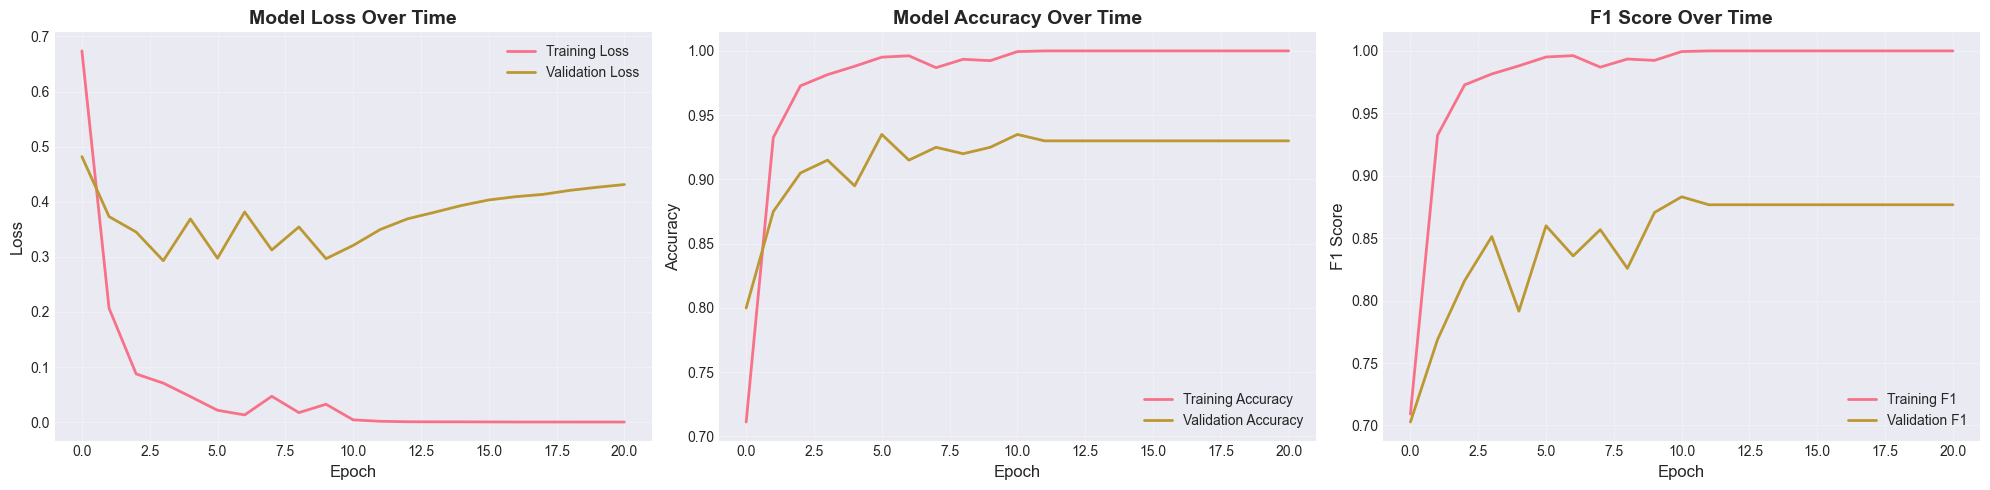


📊 Final Training Metrics (Best Configuration):
Training Loss: 0.0003
Training Accuracy: 1.0000
Validation Loss: 0.4312
Validation Accuracy: 0.9300
Validation F1: 0.8768


In [46]:
# Visualize training history of the best configuration
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Loss
axes[0].plot(best_history['loss'], label='Training Loss', linewidth=2)
axes[0].plot(best_history['val_loss'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(best_history['accuracy'], label='Training Accuracy', linewidth=2)
axes[1].plot(best_history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# F1 score
axes[2].plot(best_history['f1_score'], label='Training F1', linewidth=2)
axes[2].plot(best_history['val_f1_score'], label='Validation F1', linewidth=2)
axes[2].set_xlabel('Epoch', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)
axes[2].set_title('F1 Score Over Time', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n📊 Final Training Metrics (Best Configuration):")
print("=" * 50)
print(f"Training Loss: {best_history['loss'][-1]:.4f}")
print(f"Training Accuracy: {best_history['accuracy'][-1]:.4f}")
print(f"Validation Loss: {best_history['val_loss'][-1]:.4f}")
print(f"Validation Accuracy: {best_history['val_accuracy'][-1]:.4f}")
print(f"Validation F1: {best_history['val_f1_score'][-1]:.4f}")

In [47]:
# Make predictions on validation set with the best model
print("🔮 Evaluating best model on validation set...\n")

y_pred_probs = best_model.predict(X_val_seq)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate F1-scores
f1_macro = f1_score(y_val_enc, y_pred_classes, average='macro')
f1_weighted = f1_score(y_val_enc, y_pred_classes, average='weighted')
f1_per_class = f1_score(y_val_enc, y_pred_classes, average=None)

print("🎯 F1-SCORE RESULTS (PRIMARY METRIC):")
print("=" * 50)
print(f"Macro F1-Score:    {f1_macro:.4f} ⭐")
print(f"Weighted F1-Score: {f1_weighted:.4f}")
print("\nF1-Score per class:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  {label:15s}: {f1_per_class[i]:.4f}")
print("\n" + "=" * 50)

# Classification report
print("📋 Classification Report:")
print("=" * 70)
print(classification_report(y_val_enc, y_pred_classes, 
                          target_names=label_encoder.classes_))

# Overall accuracy
accuracy = np.mean(y_pred_classes == y_val_enc)
print(f"\n✨ Overall Validation Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

🔮 Evaluating best model on validation set...

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
🎯 F1-SCORE RESULTS (PRIMARY METRIC):
Macro F1-Score:    0.8831 ⭐
Weighted F1-Score: 0.9317

F1-Score per class:
  high_pain      : 0.8667
  low_pain       : 0.8235
  no_pain        : 0.9592

📋 Classification Report:
              precision    recall  f1-score   support

   high_pain       1.00      0.76      0.87        17
    low_pain       0.95      0.72      0.82        29
     no_pain       0.93      0.99      0.96       154

    accuracy                           0.94       200
   macro avg       0.96      0.83      0.88       200
weighted avg       0.94      0.94      0.93       200


✨ Overall Validation Accuracy: 0.9350 (93.50%)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
🎯 F1-SCORE RESULTS (PRIMARY METRIC):
Macro F1-Score:    0.8831 ⭐
Weighted F1-Score: 0.9317

F1-Score per class:
  high_pain      : 0.8667
  low_pain       : 0.8235
  no_pain        : 0.9592

📋 Classification Report:
              pre

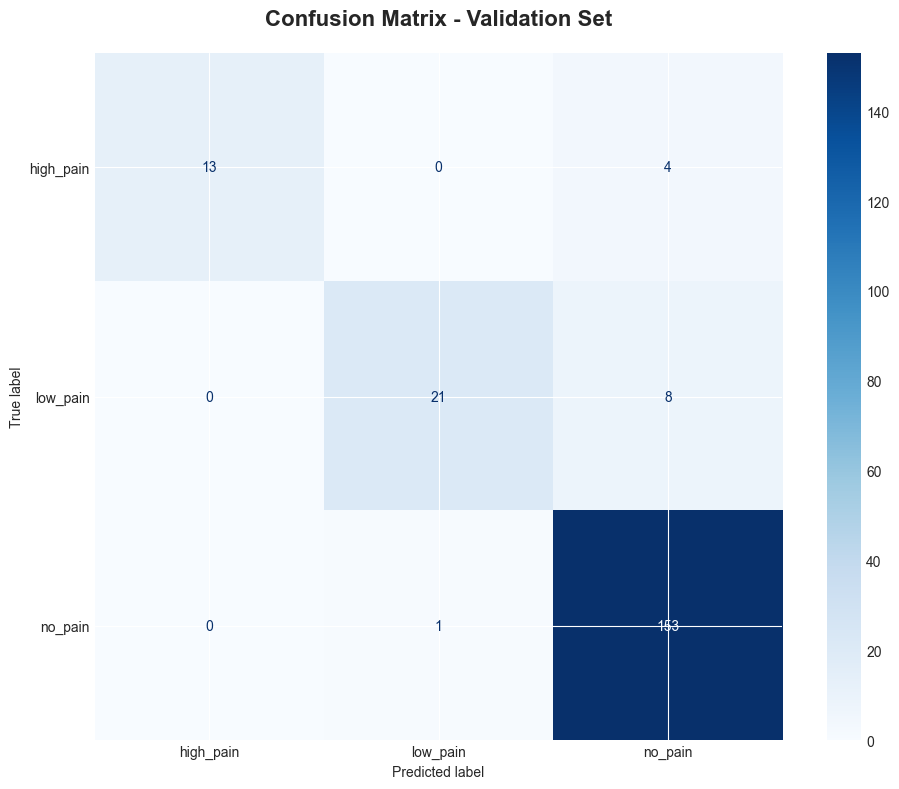


🔍 Confusion Matrix Analysis:
high_pain:
  Correct: 13/17 (76.5%)
  Misclassified: 4
low_pain:
  Correct: 21/29 (72.4%)
  Misclassified: 8
no_pain:
  Correct: 153/154 (99.4%)
  Misclassified: 1


In [48]:
# Confusion matrix
cm = confusion_matrix(y_val_enc, y_pred_classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix - Validation Set', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Detailed confusion matrix analysis
print("\n🔍 Confusion Matrix Analysis:")
print("=" * 50)
for i, label in enumerate(label_encoder.classes_):
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"{label}:")
    print(f"  Correct: {correct}/{total} ({correct/total*100:.1f}%)")
    print(f"  Misclassified: {total-correct}")

In [49]:
# Load test data
print("📂 Loading test data...")
X_test = pd.read_csv('pirate_pain_test.csv')

print(f"Test data shape: {X_test.shape}")
print(f"Number of test samples: {X_test['sample_index'].nunique()}")
print("\n📊 First few rows:")
display(X_test.head())

📂 Loading test data...
Test data shape: (211840, 40)
Number of test samples: 1324

📊 First few rows:
Test data shape: (211840, 40)
Number of test samples: 1324

📊 First few rows:


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,2,2,2,two,two,two,0.842535,...,0.000003,0.000004,0.000003,0.000003,0.000068,0.019372,0.066324,0.022228,0.013576,0.5
1,0,1,2,2,2,2,two,two,two,0.898836,...,0.000003,0.000004,0.000004,0.000003,0.000029,0.069747,0.080417,0.023650,0.038793,0.5
2,0,2,2,2,2,2,two,two,two,0.957765,...,0.000006,0.000004,0.000009,0.000004,0.000008,0.054968,0.058811,0.027023,0.054202,0.5
3,0,3,1,2,2,2,two,two,two,0.832596,...,0.000005,0.000004,0.000003,0.000004,0.000015,0.048695,0.047128,0.016151,0.024983,0.5
4,0,4,2,2,2,0,two,two,two,0.805971,...,0.000006,0.000004,0.000003,0.000003,0.000008,0.019762,0.031116,0.015618,0.017931,0.5


In [50]:
# Prepare test sequences
print("\n🔄 Preparing test sequences...")

test_samples = []
test_sample_indices = []

unique_test_samples = X_test['sample_index'].unique()

for sample_idx in unique_test_samples:
    # Get all time steps for this sample
    sample_data = X_test[X_test['sample_index'] == sample_idx].copy()
    sample_data = sample_data.sort_values('time')
    
    # Preprocess and scale features using the training scaler
    features = preprocess_features(sample_data)
    features_scaled = scaler.transform(features)
    test_samples.append(features_scaled.astype(np.float32))
    test_sample_indices.append(sample_idx)

print(f"✅ Created {len(test_samples)} test sequences")

# Pad or truncate to match the training sequence length
X_test_seq = np.zeros((len(test_samples), sequence_length, n_features), dtype=np.float32)
for i, sample in enumerate(test_samples):
    seq_len = sample.shape[0]
    if seq_len >= sequence_length:
        X_test_seq[i] = sample[:sequence_length]
    else:
        X_test_seq[i, :seq_len, :] = sample
        # Remaining timesteps stay zero-padded

print(f"✅ Test tensor shape: {X_test_seq.shape}")


🔄 Preparing test sequences...
✅ Created 1324 test sequences
✅ Test tensor shape: (1324, 160, 143)
✅ Created 1324 test sequences
✅ Test tensor shape: (1324, 160, 143)



🔮 Generating predictions...
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
✅ Generated 1324 predictions

📊 Prediction distribution:
no_pain      984
low_pain     182
high_pain    158
Name: count, dtype: int64
✅ Generated 1324 predictions

📊 Prediction distribution:
no_pain      984
low_pain     182
high_pain    158
Name: count, dtype: int64


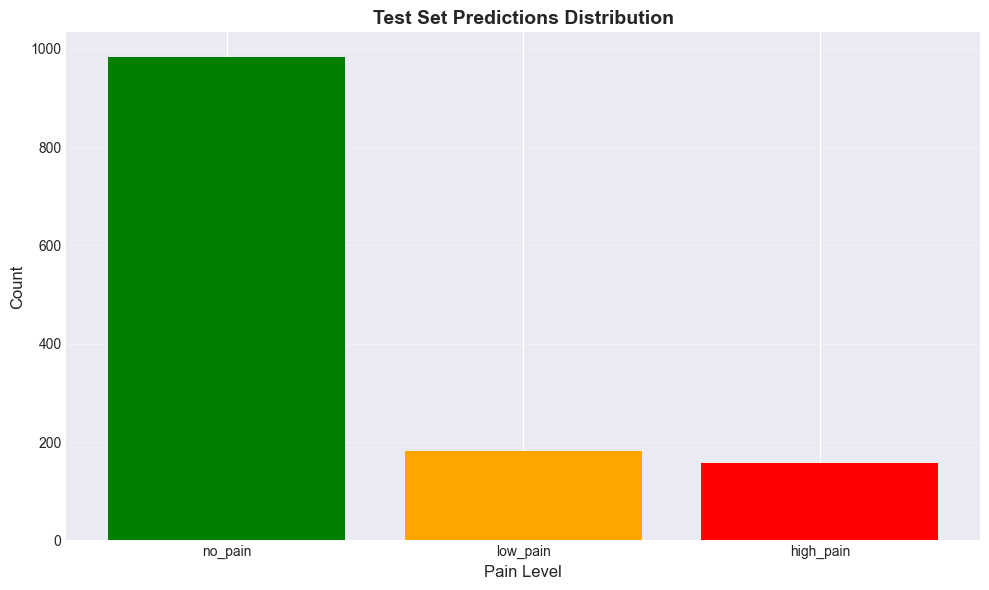

In [51]:
# Make predictions
print("\n🔮 Generating predictions...")

y_test_probs = best_model.predict(X_test_seq)
y_test_classes = np.argmax(y_test_probs, axis=1)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

print(f"✅ Generated {len(y_test_labels)} predictions")

# Show prediction distribution
pred_dist = pd.Series(y_test_labels).value_counts()
print("\n📊 Prediction distribution:")
print(pred_dist)

# Visualize
plt.figure(figsize=(10, 6))
colors_map = {'no_pain': 'green', 'low_pain': 'orange', 'high_pain': 'red'}
bar_colors = [colors_map.get(label, 'gray') for label in pred_dist.index]
plt.bar(pred_dist.index, pred_dist.values, color=bar_colors)
plt.xlabel('Pain Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Test Set Predictions Distribution', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
# Create submission
print("📝 Creating submission file...\n")

# Format sample indices as zero-padded 3-digit strings
formatted_indices = [f"{int(idx):03d}" for idx in test_sample_indices]

submission = pd.DataFrame({
    'sample_index': formatted_indices,
    'label': y_test_labels
})

# Save as comma-separated file
submission_path = 'submission.csv'
submission.to_csv(submission_path, index=False)

print("✅ Submission file created: submission.csv")
print(f"   Format: Comma-separated (CSV)")
print(f"   Rows: {len(submission)}")
print(f"\n📋 First 15 predictions:")
print("=" * 40)
display(submission.head(15))

print("\n✨ Submission ready for upload!")

📝 Creating submission file...

✅ Submission file created: submission.csv
   Format: Comma-separated (CSV)
   Rows: 1324

📋 First 15 predictions:
✅ Submission file created: submission.csv
   Format: Comma-separated (CSV)
   Rows: 1324

📋 First 15 predictions:


,sample_index,label
0,000,no_pain
1,001,no_pain
2,002,no_pain
3,003,no_pain
4,004,no_pain
5,005,low_pain
6,006,no_pain
7,007,no_pain
8,008,high_pain
9,009,no_pain



✨ Submission ready for upload!
